# Stage 08 — Exploratory Data Analysis (ASML)
Checklist: structure & missingness → numeric profile → distributions → relationships → correlation (optional) → 3 insights.


Imports, env, paths

In [1]:
from __future__ import annotations
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Resolve project root when running from project/notebooks
project_root = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd().resolve()
sys.path.append(str(project_root / "src"))

load_dotenv(project_root / ".env")

from storage import env_paths, read_df
RAW_DIR, PROC_DIR = env_paths(project_root)
RAW_DIR, PROC_DIR


(WindowsPath('C:/Users/melin/OneDrive/Desktop/nyu/python/bootcamp_panagiotis_housos/project/data/raw'),
 WindowsPath('C:/Users/melin/OneDrive/Desktop/nyu/python/bootcamp_panagiotis_housos/project/data/processed'))

Load dataset (prefer cleaned; else raw)

In [2]:
# Prefer cleaned processed file if available
clean_candidates = sorted(PROC_DIR.glob("asml_cleaned_*.parquet")) + sorted(PROC_DIR.glob("asml_cleaned_*.csv"))
raw_candidates   = sorted(RAW_DIR.glob("api_*ASML_*.csv"))

if clean_candidates:
    path = clean_candidates[-1]
    print("Using CLEANED:", path.name)
    df = read_df(path, parse_dates=["date"])
elif raw_candidates:
    path = raw_candidates[-1]
    print("Using RAW:", path.name)
    df = read_df(path, parse_dates=["date"])
else:
    raise FileNotFoundError("No ASML files found. Please run Stage 04/06 first.")

df = df.sort_values("date").reset_index(drop=True)
price_col = "adjusted_close" if "adjusted_close" in df.columns else "close"
df["ret"] = df[price_col].pct_change()
df.head()


Using CLEANED: asml_cleaned_20250818-2218.csv


,date,open,high,low,close,adjusted_close,volume,ret
0,2020-08-17,376.660004,380.500000,376.250000,378.510010,364.919250,428200,NaN
1,2020-08-18,383.609985,383.980011,376.989990,377.220001,363.675568,466500,-0.003408
2,2020-08-19,380.390015,380.429993,373.959991,374.940002,361.477417,354400,-0.006044
3,2020-08-20,369.540009,373.380005,368.380005,372.170013,358.806976,498200,-0.007388
4,2020-08-21,366.149994,372.130005,365.540009,372.119995,358.758667,605400,-0.000135


Structure & missingness

In [3]:
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())


Shape: (1256, 8)

Dtypes:
 date              datetime64[ns]
open                     float64
high                     float64
low                      float64
close                    float64
adjusted_close           float64
volume                     int64
ret                      float64
dtype: object

Missing values per column:
 date              0
open              0
high              0
low               0
close             0
adjusted_close    0
volume            0
ret               1
dtype: int64


Numeric profile (describe + skew/kurtosis)

In [4]:
num = df.select_dtypes(include=np.number)
display(num.describe())

skew  = num.skew(numeric_only=True)
kurt  = num.kurtosis(numeric_only=True)
profile = pd.DataFrame({"skew": skew, "kurtosis": kurt})
profile


,open,high,low,close,adjusted_close,volume,ret
count,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03,1255.000000
mean,678.850454,686.794220,670.238878,678.743702,666.344966,1.168229e+06,0.000906
std,153.219952,154.222459,151.349806,152.712068,153.400937,7.885815e+05,0.026081
min,345.369995,353.390015,343.250000,347.350006,334.878082,2.364000e+05,-0.162610
25%,584.015015,592.634995,576.274979,583.964996,572.676926,7.486500e+05,-0.013262
50%,676.375000,683.545013,669.654999,678.285004,666.644836,9.896000e+05,0.000770
75%,761.352509,768.175003,751.027496,757.642517,749.202637,1.358625e+06,0.016178
max,1109.979980,1110.089966,1075.829956,1098.949951,1088.973999,1.078960e+07,0.154341


,skew,kurtosis
open,0.139959,-0.064882
high,0.143083,-0.041438
low,0.131704,-0.088220
close,0.136012,-0.058439
adjusted_close,0.142972,-0.058777
volume,5.338897,48.641038
ret,-0.025017,3.600629


Distributions (histogram + boxplot for returns)

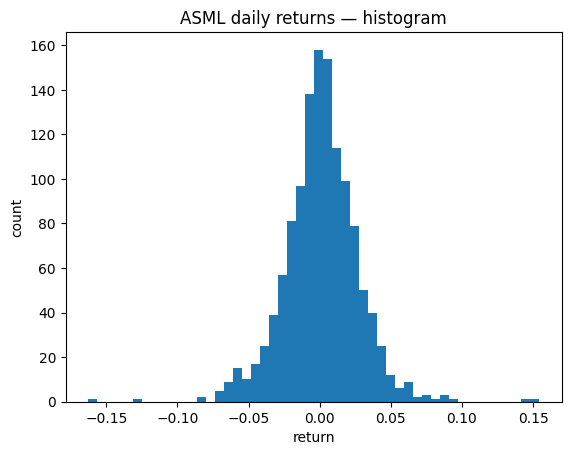

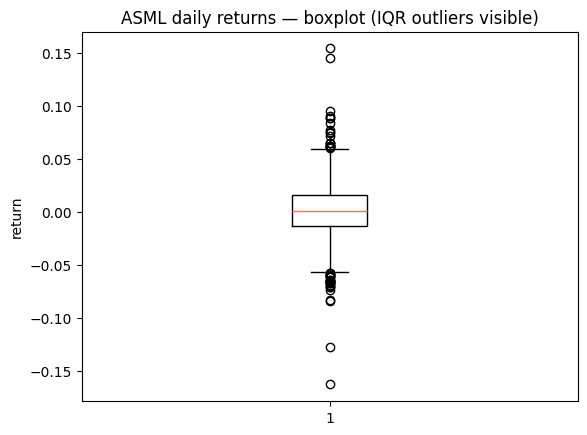

In [5]:
# Drop NaNs for plotting
rets = df["ret"].dropna()

plt.figure()
plt.hist(rets, bins=50)
plt.title("ASML daily returns — histogram")
plt.xlabel("return"); plt.ylabel("count")
plt.show()

plt.figure()
plt.boxplot(rets, vert=True)
plt.title("ASML daily returns — boxplot (IQR outliers visible)")
plt.ylabel("return")
plt.show()


Relationships (time series + lag scatter)

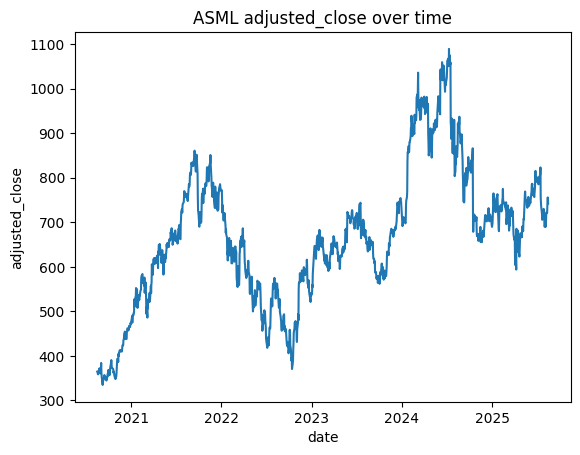

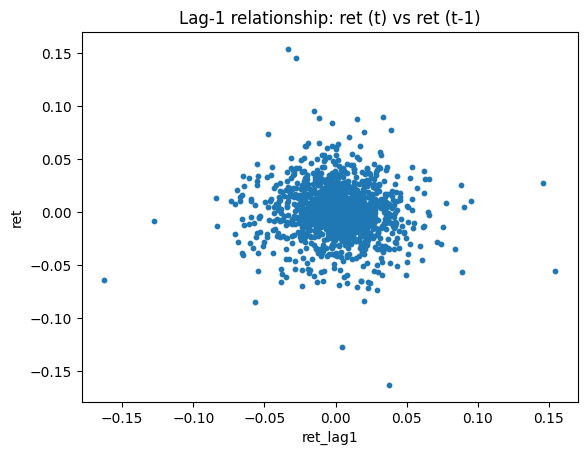

In [6]:
# Time series of price
plt.figure()
plt.plot(df["date"], df[price_col])
plt.title(f"ASML {price_col} over time")
plt.xlabel("date"); plt.ylabel(price_col)
plt.show()

# Lag-1 scatter for returns
df["ret_lag1"] = df["ret"].shift(1)
mask = df["ret"].notna() & df["ret_lag1"].notna()
plt.figure()
plt.scatter(df.loc[mask, "ret_lag1"], df.loc[mask, "ret"], s=10)
plt.title("Lag-1 relationship: ret (t) vs ret (t-1)")
plt.xlabel("ret_lag1"); plt.ylabel("ret")
plt.show()


Correlation matrix

In [7]:
cols_for_corr = [c for c in ["open","high","low","close","adjusted_close","volume","ret","ret_lag1"] if c in df.columns]
corr = df[cols_for_corr].corr(numeric_only=True)
corr


,open,high,low,close,adjusted_close,volume,ret,ret_lag1
open,1.000000,0.998804,0.998253,0.996564,0.995601,0.093748,-0.019751,0.033146
high,0.998804,1.000000,0.998193,0.998329,0.997348,0.102782,0.004750,0.030115
low,0.998253,0.998193,1.000000,0.998806,0.997781,0.071844,0.011909,0.034067
close,0.996564,0.998329,0.998806,1.000000,0.998921,0.082778,0.037571,0.031032
adjusted_close,0.995601,0.997348,0.997781,0.998921,1.000000,0.097833,0.036288,0.029934
volume,0.093748,0.102782,0.071844,0.082778,0.097833,1.000000,-0.099717,-0.103202
ret,-0.019751,0.004750,0.011909,0.037571,0.036288,-0.099717,1.000000,-0.055776
ret_lag1,0.033146,0.030115,0.034067,0.031032,0.029934,-0.103202,-0.055776,1.000000
